# Notebook to prepare the auxiliary data for the Casa Grande site for the History project

The following data are prepared:
- reference lidar 1 m DEM over Maricopa country, provided by the USGS: https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/1m/Projects/AZ_MaricopaPinal_2020_B20/
- Copernicus 30 m DEM: 1x1 degree tiles are downloaded, merged and reprojected on the same horizontal and vertical reference system as lidar DEM. It is then coregistered horizontally with a Nuth & Kaan (2011) algorithm and vertically by calculating a median shift in stable areas. Stable areas are defined as bare land, grassland and shrubland in the ESA worldcover (see below) and excluding sibsiding land (see below).
- ESA worldcover dataset 10 m: each 1x1 degree tile are downloaded from the S3 bucket and merged
- Land subsidence vector file downloaded from https://azgeo-open-data-agic.hub.arcgis.com/datasets/azwater::land-subsidence/explore


In [1]:
import os
import subprocess
from glob import glob
import folium

import xdem
import matplotlib.pyplot as plt
import geoutils as gu
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import rasterio
import history

/home/godinlu/micromamba/envs/history/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global settings

In [2]:
VISUALIZATION = True
OVERWRITE = False

# PATH SETTINGS

OUTPUT_DIRECTORY = "./data/casa_grande/aux_data/"
VISUALIZATION_DIRECTORY = "./visualizations"

# final generated files
LARGE_DEM_FILE = os.path.join(OUTPUT_DIRECTORY, "reference_dem_large.tif")
ZOOM_DEM_FILE = os.path.join(OUTPUT_DIRECTORY, "reference_dem_zoom.tif")
LARGE_DEM_MASK_FILE = os.path.join(OUTPUT_DIRECTORY, "reference_dem_large_mask.tif")
ZOOM_DEM_MASK_FILE = os.path.join(OUTPUT_DIRECTORY, "reference_dem_zoom_mask.tif")

# temporary directory to download tiles and process
TMP_DIRECTORY = os.path.join(OUTPUT_DIRECTORY, "tmp")

LANDCOVER_DIRECTORY = os.path.join(TMP_DIRECTORY, "landcover")
LIDARDEM_DIRECTORY = os.path.join(TMP_DIRECTORY, "lidar_dem")
COP30DEM_DIRECTORY = os.path.join(TMP_DIRECTORY, "cop30_dem")

os.makedirs(TMP_DIRECTORY, exist_ok=True)
os.makedirs(VISUALIZATION_DIRECTORY, exist_ok=True)

## ! IMPORTANT !

you need to download the land subsidence mask manually at: https://azgeo-open-data-agic.hub.arcgis.com/datasets/azwater::land-subsidence/explore


In [3]:
land_subsidence_file = os.path.join(TMP_DIRECTORY, "Land_Subsidence.geojson")
assert os.path.exists(land_subsidence_file)

## Define bounding box

We define 2 bounding box : 
- `zoom_bounds` : for lidar DEM of 1m resolution
- `large_bounds` : for copernicus DEM of 30m resolution

In [4]:
# Bounding box of the two area of interest
zoom_bounds = [414000, 3613020, 444000, 3650010]
large_bounds = [261990, 3405030, 612990, 3880020]
epsg_str = "EPSG:26912"

# Save to gjson files
zoom_gdf = gpd.GeoDataFrame(geometry=[gu.projtools.bounds2poly(zoom_bounds),], crs=epsg_str)
zoom_gdf.to_file(os.path.join(TMP_DIRECTORY, "zoom_aoi.geojson"))

large_gdf = gpd.GeoDataFrame(geometry=[gu.projtools.bounds2poly(large_bounds),], crs=epsg_str)
large_gdf.to_file(os.path.join(TMP_DIRECTORY, "large_aoi.geojson"))

zoom_bounds_latlon = gu.projtools.bounds2poly(zoom_bounds, in_crs=epsg_str, out_crs="EPSG:4326").bounds
large_bounds_latlon = gu.projtools.bounds2poly(large_bounds, in_crs=epsg_str, out_crs="EPSG:4326").bounds

# and swap axes for lon/lat
zoom_bounds_lonlat = [zoom_bounds_latlon[k] for k in [1, 0, 3, 2]]
large_bounds_lonlat = [large_bounds_latlon[k] for k in [1, 0, 3, 2]]

## [Optional] Visualisation of bounding box and land subsidence

In [5]:
if VISUALIZATION:
    gdf = gpd.read_file(land_subsidence_file)

    centroid_proj = gdf.to_crs("EPSG:26912").union_all().centroid
    centroid_ll = gpd.GeoSeries([centroid_proj], crs="EPSG:26912").to_crs("EPSG:4326").geometry[0]

    m = folium.Map(location=[centroid_ll.y, centroid_ll.x], zoom_start=7)
    folium.GeoJson(data=gdf).add_to(m)
    folium.GeoJson(data=zoom_gdf.to_crs(epsg=4326)).add_to(m)
    folium.GeoJson(data=large_gdf.to_crs(epsg=4326)).add_to(m)
m

## Download and processing Lidar DEM

In [6]:
os.makedirs(LIDARDEM_DIRECTORY, exist_ok=True)

if OVERWRITE or (not os.path.exists(ZOOM_DEM_FILE)):
    print("\nProcessing Lidar DEM")
    # Download tiles
    # Note: the list of files has been manually restricted to only cover the zoom area
    cmd = f"wget -c -r -np -nd -A '*x4[1-4]*y36[1-5]*.tif' -P {LIDARDEM_DIRECTORY} https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/1m/Projects/AZ_MaricopaPinal_2020_B20/TIFF/"
    print(cmd), subprocess.run(cmd, shell=True, check=True)
    
    # Create mosaic
    list_fn = os.path.join(LIDARDEM_DIRECTORY, "list_tiles.txt")
    tiles_downloaded = pd.Series(glob(os.path.join(LIDARDEM_DIRECTORY, "USGS_1M*tif")))
    tiles_downloaded.to_csv(list_fn, header=False, index=False)

    tmp_vrt_fn = os.path.join(LIDARDEM_DIRECTORY, "tmp.vrt")
    cmd = f"gdalbuildvrt -r cubic {tmp_vrt_fn} -input_file_list {list_fn} -resolution highest"
    print(cmd), subprocess.run(cmd, shell=True, check=True)

    # Load and crop to zoom extent
    lidar_dem = xdem.DEM(tmp_vrt_fn).crop(zoom_bounds)

    # Convert from NAVD88 geoid to ellipsoid - very memory intensive !
    # The file was selected from https://cdn.proj.org/ and compared to ASP's dem_geoid (script test_datum.py)
    # The mean diff with ASP is 0.4 mm and std of 5 mm, reason?
    # According to report https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/metadata/AZ_MaricopaPinal_2020_B20/USGS_AZ_MaricopaPinal_2020_B20_Project_Report.pdf, the geoid should be GEOID18, while this is geoid09.
    print("\nChanging vertical datum - this takes a few minutes\n")
    lidar_dem.set_vcrs("us_noaa_geoid09_conus.tif")
    lidar_dem = lidar_dem.to_vcrs("WGS84")

    # Save
    lidar_dem.save(ZOOM_DEM_FILE, tiled=True)

    print("\nDone with Lidar DEM\n")
else:
    print(f"Using existing lidar dem {ZOOM_DEM_FILE}")

Using existing lidar dem ./data/casa_grande/aux_data/reference_dem_zoom.tif


## [Optional] Visualisation of the lidar DEM 

Note : we downscale the resolution of 10%


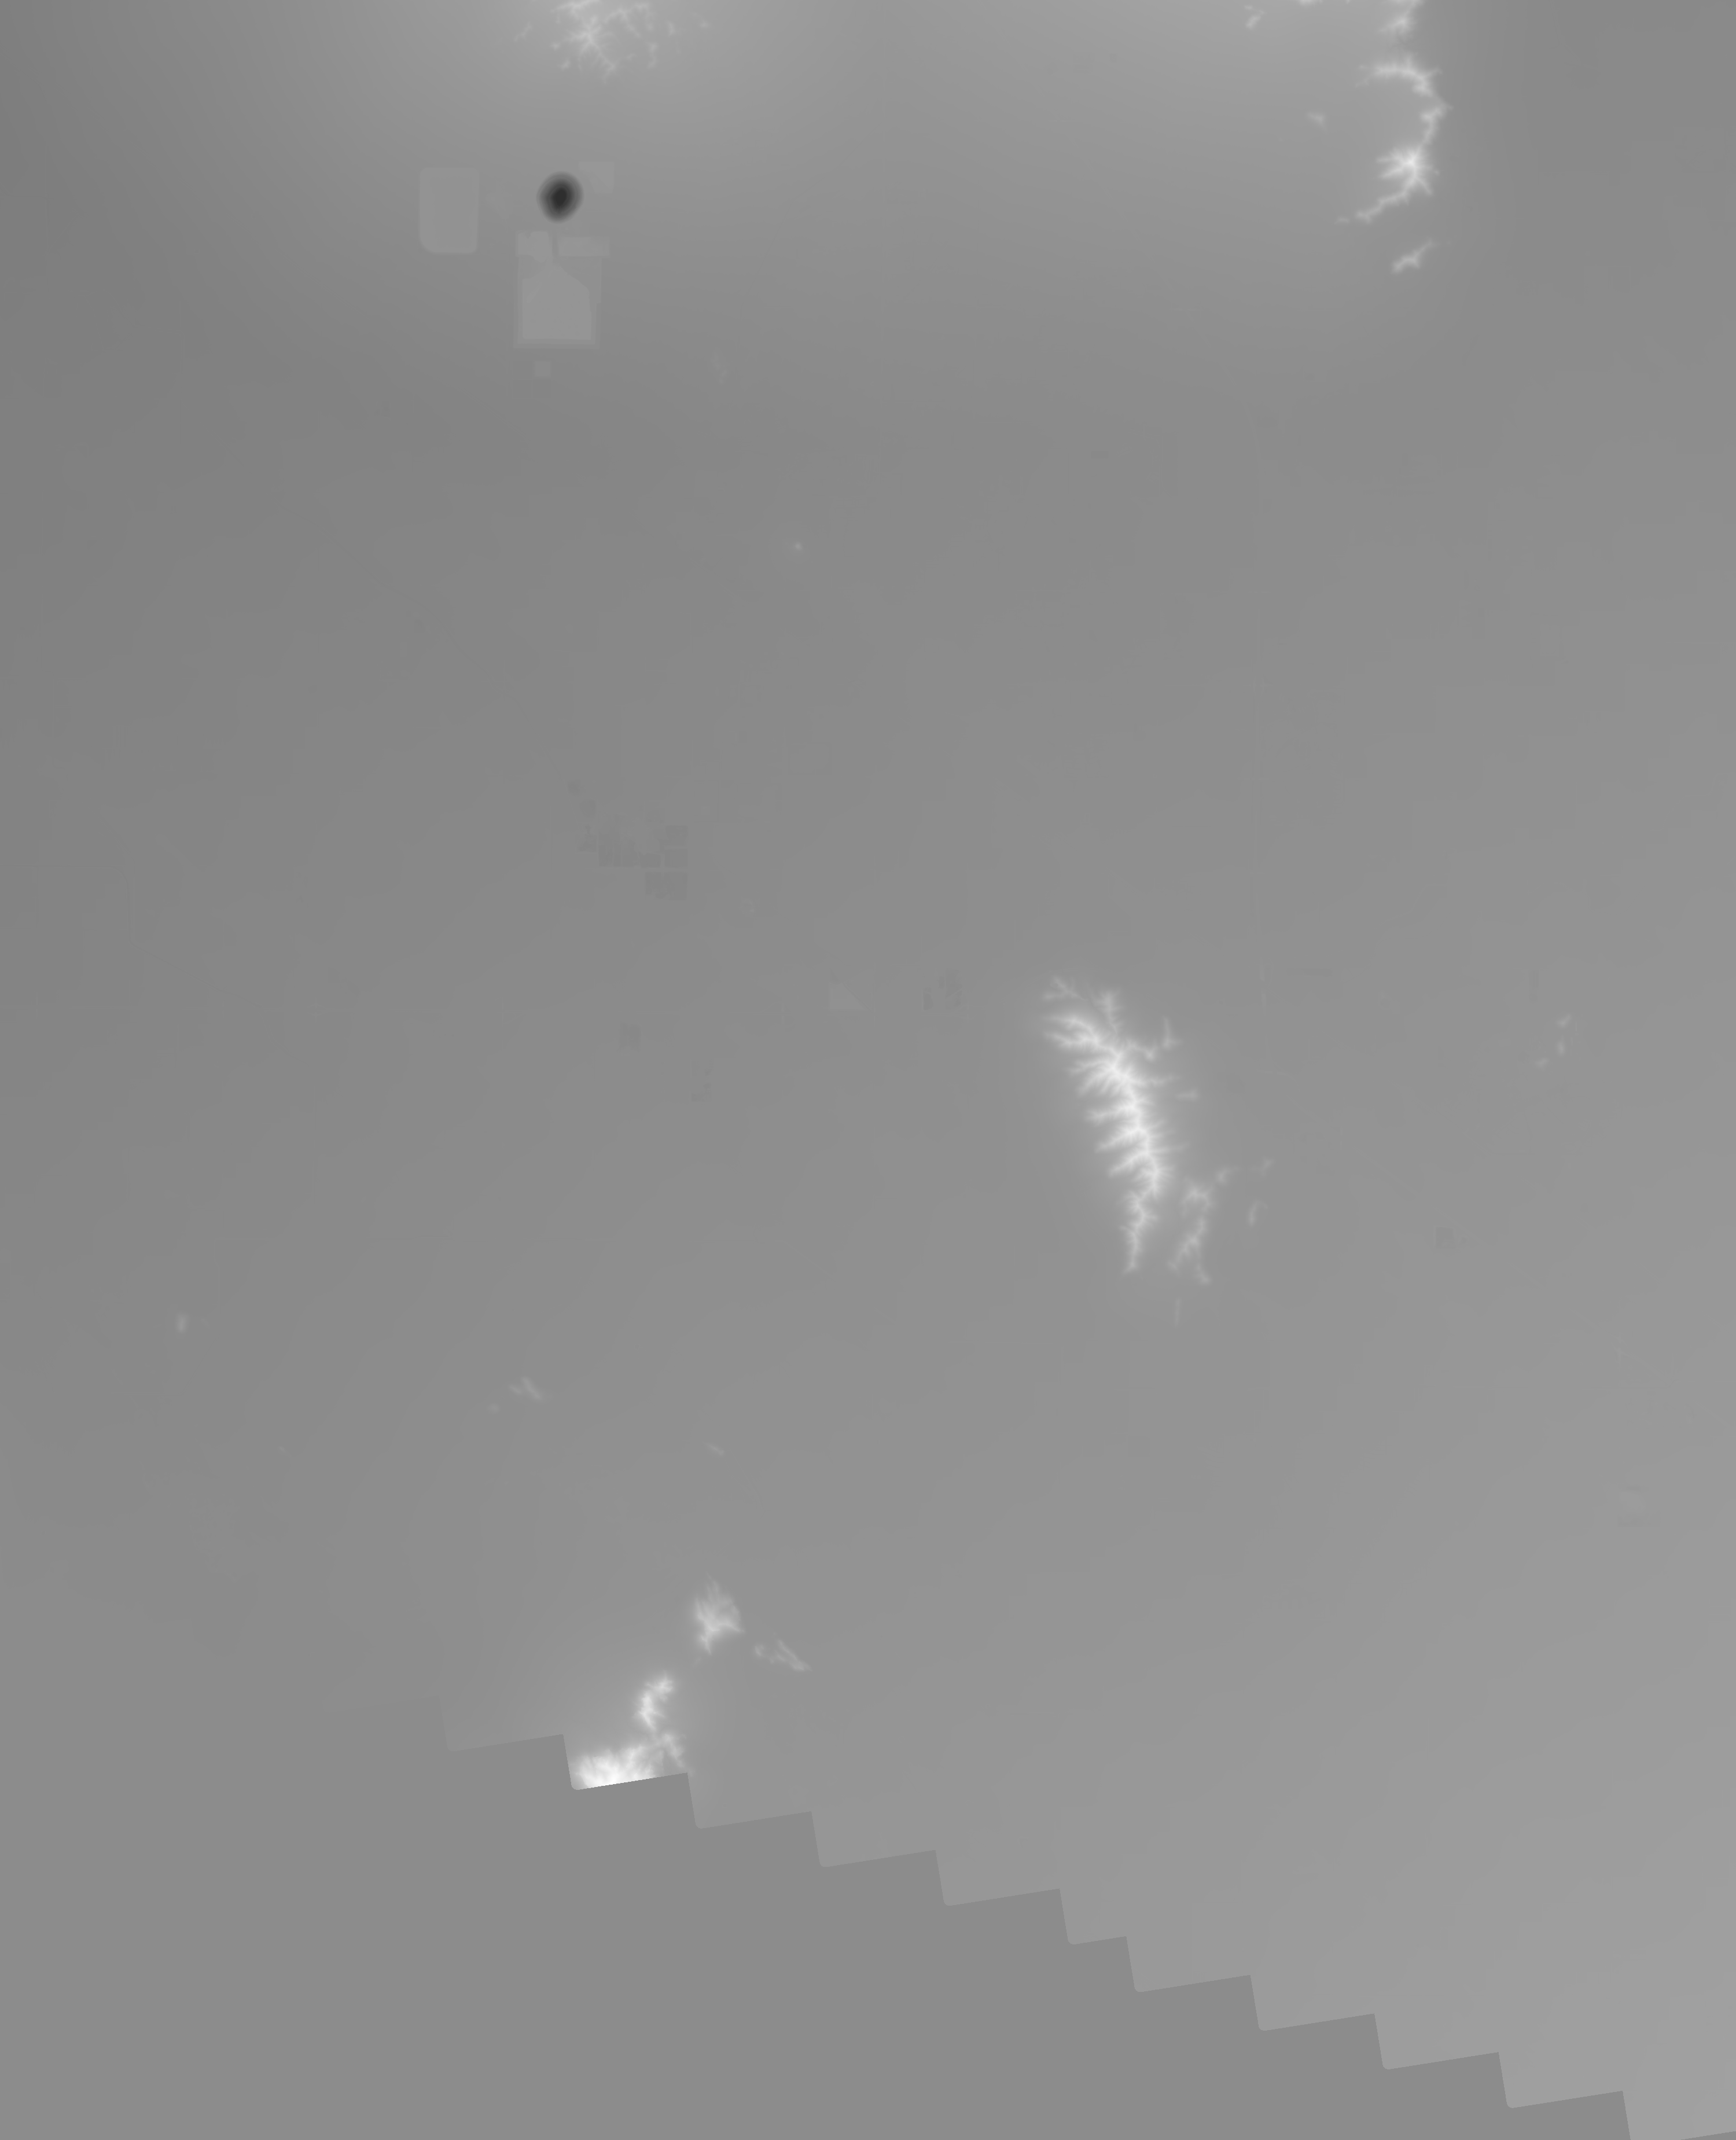

In [7]:
scale = 0.1 # 10% of the resolution

with rasterio.open(ZOOM_DEM_FILE) as src:
    gdf = gpd.GeoDataFrame(geometry=[gu.projtools.bounds2poly(src.bounds)], crs=src.crs)
    centroid_ll = gdf.centroid.to_crs("EPSG:4326")[0]
    dem = src.read(1, out_shape=(1, int(src.height*scale), int(src.width * scale)), resampling=rasterio.enums.Resampling.average)

minx, miny, maxx, maxy = gdf.to_crs("EPSG:4326").total_bounds
image_bounds = [[miny, minx], [maxy, maxx]]

m = folium.Map(location=[centroid_ll.y, centroid_ll.x], zoom_start=11)

folium.raster_layers.ImageOverlay(
    name="Landcover Preview",
    image=dem,
    bounds=[image_bounds],
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)
m

# Download and processing copernicus DEM

In [8]:
os.makedirs(COP30DEM_DIRECTORY, exist_ok=True)

cop30_large_uncoreg_fn = os.path.join(COP30DEM_DIRECTORY, "cop30_large_uncoreg.tif")

if OVERWRITE or (not os.path.exists(cop30_large_uncoreg_fn)):

    print("\nProcessing COP30 DEM")
    # - Download tiles -
    # Round bbox to nearest degree, outward.
    bbox = np.array([
        np.floor(large_bounds_lonlat[0]),
        np.floor(large_bounds_lonlat[1]),
        np.ceil(large_bounds_lonlat[2]),
        np.ceil(large_bounds_lonlat[3]),
    ],dtype="int")

    cop30_tiles = history.aux_data.download_tools.download_cop30_tiles(bbox, COP30DEM_DIRECTORY, overwrite=OVERWRITE)

    # - Create mosaic -
    cop30_tiles_avail = pd.Series([tile for tile in cop30_tiles if os.path.exists(tile)])
    list_fn = os.path.join(COP30DEM_DIRECTORY, "list_tiles.txt")
    cop30_tiles_avail.to_csv(list_fn, header=False, index=False)

    # Note - options "-r cubic" and "-resolution highest" are very important otherwise shifts/artifacts can occur
    tmp_vrt_fn = os.path.join(COP30DEM_DIRECTORY, "tmp.vrt")
    cmd = f"gdalbuildvrt -r cubic {tmp_vrt_fn} -input_file_list {list_fn} -resolution highest"
    print(cmd); subprocess.run(cmd, shell=True, check=True)

    # Sanity check - the mosaic should be equal to the original tiles
    history.aux_data.download_tools.geodiff(tmp_vrt_fn, cop30_tiles_avail[1], vmax=1)

    # Reproject and crop
    vrt_mosaic = xdem.DEM(tmp_vrt_fn)
    bounds = dict(zip(["left", "bottom", "right", "top"], large_bounds))
    cop30_large = vrt_mosaic.reproject(crs=epsg_str, bounds=bounds, res=30)

    # sanity check - the mosaic should roughly equal to the original tiles
    for tile_fn in cop30_tiles_avail:
        print(f"Checking vs tile {tile_fn}")
        tile = xdem.DEM(tile_fn)
        ddem = tile - cop30_large.reproject(tile)
        assert np.std(ddem) < 1.5
        assert np.max(np.abs(ddem)) < 30
        assert abs(np.mean(ddem)) < 1e-1 # can not pass with 1e-2

    # -- Convert geoid to ellipsoid
    cop30_large.set_vcrs("EGM08")
    cop30_large = cop30_large.to_vcrs("WGS84")

    # Save
    cop30_large.save(cop30_large_uncoreg_fn, tiled=True)
    print("\nDone with COP30 DEM\n")

else:
    print(f"Using existing COP30 dem {cop30_large_uncoreg_fn}")

Using existing COP30 dem ./data/casa_grande/aux_data/tmp/cop30_dem/cop30_large_uncoreg.tif


## [Optional] Visualisation of the copernicus 30 DEM 

Note : we downscale the resolution of 10%


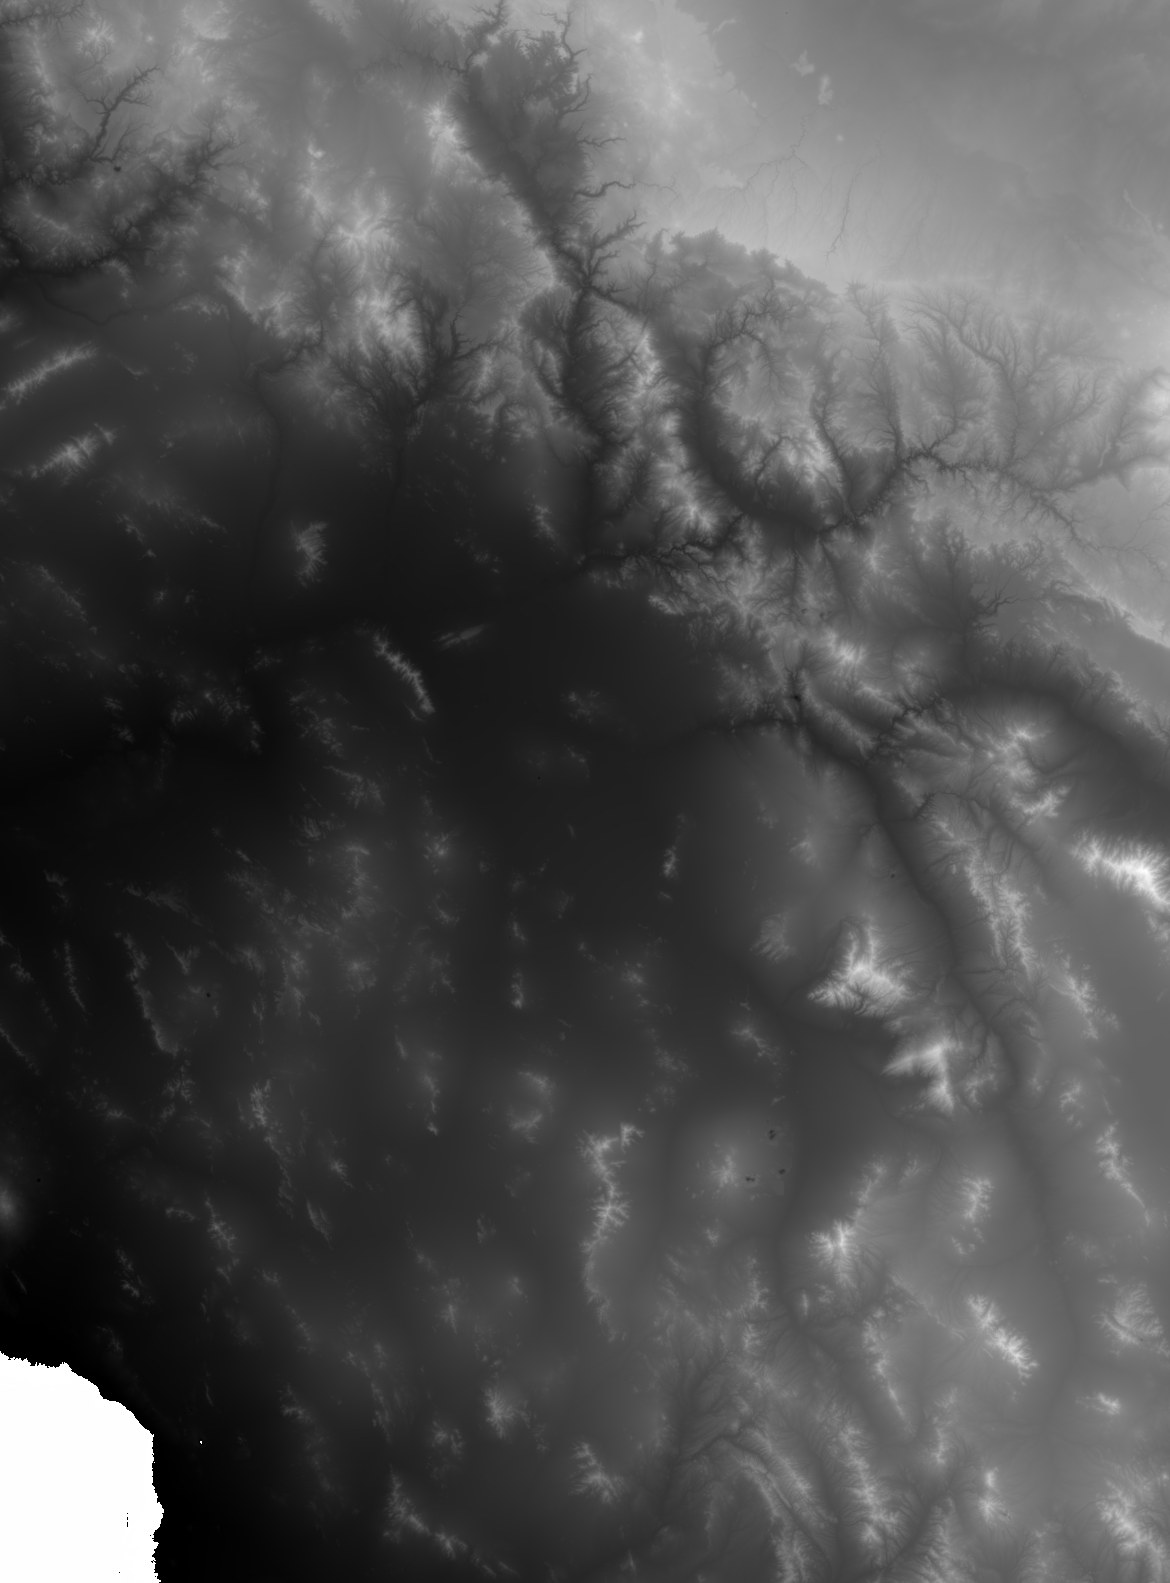

In [9]:
scale = 0.1 # 10% of the resolution

with rasterio.open(cop30_large_uncoreg_fn) as src:
    gdf = gpd.GeoDataFrame(geometry=[gu.projtools.bounds2poly(src.bounds)], crs=src.crs)
    centroid_ll = gdf.centroid.to_crs("EPSG:4326")[0]
    dem = src.read(1, out_shape=(1, int(src.height*scale), int(src.width * scale)), resampling=rasterio.enums.Resampling.average)

minx, miny, maxx, maxy = gdf.to_crs("EPSG:4326").total_bounds
image_bounds = [[miny, minx], [maxy, maxx]]

m = folium.Map(location=[centroid_ll.y, centroid_ll.x], zoom_start=7)

folium.raster_layers.ImageOverlay(
    name="Landcover Preview",
    image=dem,
    bounds=[image_bounds],
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)
m

In [5]:
os.makedirs(LANDCOVER_DIRECTORY, exist_ok=True)

landcover_vrt_fn = os.path.join(LANDCOVER_DIRECTORY, "tmp.vrt")

if OVERWRITE or (not os.path.exists(landcover_vrt_fn)):

    print("\nProcessing ESA world_landcover")
    landcover_tiles = history.aux_data.download_tools.download_esa_worldcover(LANDCOVER_DIRECTORY, large_bounds_lonlat, year=2021, overwrite=OVERWRITE, dryrun=False)

    # Create mosaic
    list_fn = os.path.join(LANDCOVER_DIRECTORY, "list_tiles.txt")
    pd.Series(landcover_tiles).to_csv(list_fn, header=False, index=False)

    cmd = f"gdalbuildvrt -r nearest {landcover_vrt_fn} -input_file_list {list_fn} -resolution highest"
    print(cmd); subprocess.run(cmd, shell=True, check=True)

    print("\nDone with ESA world_landcover\n")


Processing ESA world_landcover


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.33s/it]

gdalbuildvrt -r nearest ./data/casa_grande/aux_data/tmp/landcover/tmp.vrt -input_file_list ./data/casa_grande/aux_data/tmp/landcover/list_tiles.txt -resolution highest
0...10...20...30...40...50...60...70...80...90...100 - done.

Done with ESA world_landcover

